<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/0312_GradientBoosting_hy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [7]:
df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [8]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale", 'steel_kind', 'day_yn', 'rolling_method', 'descaling_count'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [9]:

# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1,1,1144,116,1133,59,259,...,0,0,0,0,1,0,0,1,1,1
1,32,3700,15100,1,2,1144,122,1135,53,238,...,0,0,0,0,1,0,0,1,1,1
2,33,3600,19200,2,1,1129,116,1121,55,258,...,0,0,0,0,1,0,0,1,1,1


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,...,0,0,0,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,...,0,0,0,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,...,0,0,0,0,1,0,0,1,1,1


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,spec_country,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,미국,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,미국,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,영국,선체구조용(조선용),T,주간,TMCP(온도제어)


In [10]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.2, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
781,15,2500,54600,2,1,1117,58,1156,75,227,...,0,0,1,0,1,0,0,0,0,0
431,16,3600,31400,3,2,1199,67,1181,56,203,...,0,0,0,0,1,0,0,0,1,0
105,76,2500,9300,3,1,1132,77,1124,101,281,...,0,0,0,0,1,0,0,1,0,1
806,19,2300,42800,1,2,1184,85,1168,54,218,...,0,0,0,0,1,0,0,0,0,0
267,38,2500,17900,3,1,1145,98,1150,60,225,...,1,0,0,0,0,1,0,0,0,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
781,-0.655158,-0.671266,1.286565,-0.003875,-0.982207,-1.900257,-1.068412,0.295767,0.160283,-0.306772,...,0,0,1,0,1,0,0,0,0,0
431,-0.599041,1.562785,-0.386089,1.219266,1.018115,1.975930,-0.727117,1.741624,-0.761410,-0.938093,...,0,0,0,0,1,0,0,0,1,0
105,2.768009,-0.671266,-1.979436,1.219266,-0.982207,-1.191198,-0.347901,-1.554930,1.421548,1.113700,...,0,0,0,0,1,0,0,1,0,1
806,-0.430688,-1.077457,0.435819,-1.227015,1.018115,1.266871,-0.044529,0.989778,-0.858430,-0.543517,...,0,0,0,0,1,0,0,0,0,0
267,0.635544,-0.671266,-1.359401,1.219266,-0.982207,-0.576681,0.448452,-0.051239,-0.567369,-0.359382,...,1,0,0,0,0,1,0,0,0,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,spec_country,purpose,steel_kind,day_yn,rolling_method
781,-0.655158,-0.671266,1.286565,-0.003875,-0.982207,-1.900257,-1.068412,0.295767,0.160283,-0.306772,-0.212189,한국,선체구조용(조선용),C,야간,CR(제어압연)
431,-0.599041,1.562785,-0.386089,1.219266,1.018115,1.975930,-0.727117,1.741624,-0.761410,-0.938093,-0.072083,미국,선체구조용(조선용),C,주간,CR(제어압연)
105,2.768009,-0.671266,-1.979436,1.219266,-0.982207,-1.191198,-0.347901,-1.554930,1.421548,1.113700,-1.519844,독일,선체구조용(조선용),T,야간,TMCP(온도제어)
806,-0.430688,-1.077457,0.435819,-1.227015,1.018115,1.266871,-0.044529,0.989778,-0.858430,-0.543517,0.130292,영국,선체구조용(조선용),C,야간,CR(제어압연)
267,0.635544,-0.671266,-1.359401,1.219266,-0.982207,-0.576681,0.448452,-0.051239,-0.567369,-0.359382,1.671457,일본,용접구조용,C,야간,CR(제어압연)


In [11]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier()
gb_uncust.fit(df_train_x_rd, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x_rd, df_test_y)))


Accuracy on training set: 0.976
Accuracy on test set: 0.947


In [12]:

# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.02 for lr in range(1, 10)]
for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.02,0.959,0.953
1,0.04,0.959,0.953
2,0.06,0.967,0.947
3,0.08,0.970,0.947
4,0.10,0.976,0.947
5,0.12,0.991,0.942
6,0.14,0.996,0.947
7,0.16,1.000,0.926
8,0.18,1.000,0.932


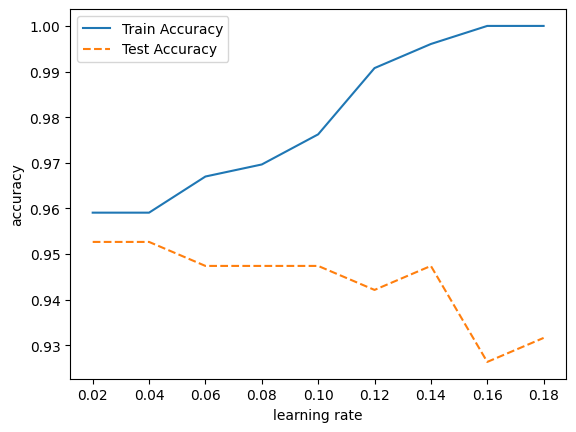

In [13]:

# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

learning rate = 0.02

In [14]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.720,0.732
1,20,0.959,0.953
2,30,0.959,0.953
3,40,0.959,0.953
4,50,0.959,0.953
5,60,0.959,0.953
6,70,0.959,0.953
7,80,0.959,0.953
8,90,0.959,0.953
9,100,0.959,0.953


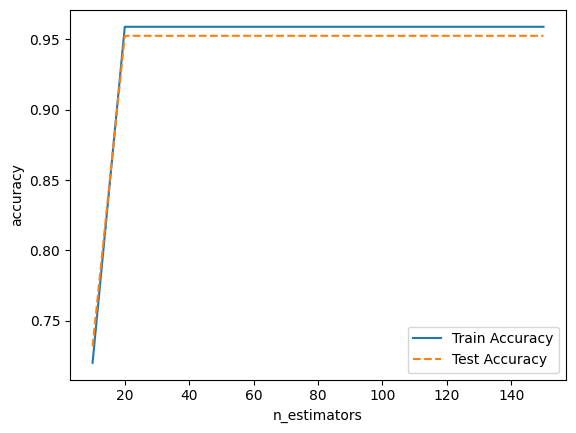

In [15]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

n_estimators = 20

In [16]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                            n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# max_depth별 정확도
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.922,0.905
1,2,0.959,0.953
2,3,0.959,0.953
3,4,0.959,0.953
4,5,0.959,0.953
5,6,0.960,0.953
6,7,0.960,0.953
7,8,0.963,0.953
8,9,0.971,0.942
9,10,0.974,0.942


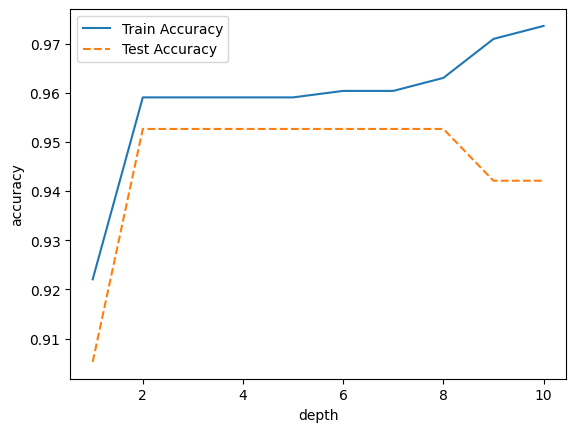

In [17]:
# 정확도를 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

max depth = 6

In [18]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 20~100
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split,
                                    max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.959,0.953
1,30,0.959,0.953
2,40,0.959,0.953
3,50,0.959,0.953
4,60,0.959,0.953
5,70,0.959,0.953
6,80,0.959,0.953
7,90,0.959,0.953
8,100,0.959,0.953


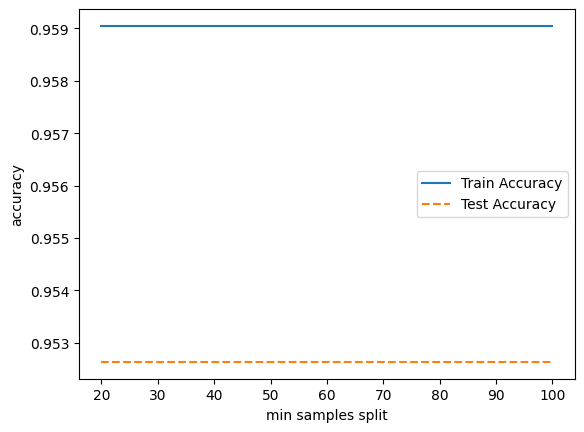

In [19]:
# 정확도를 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

모델에 영향을 주지 않는 파라미터. 지정하지 않음

In [20]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수.
para_leaf = [n_leaf * 2 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.959,0.953
1,4,0.959,0.953
2,6,0.959,0.953
3,8,0.959,0.953
4,10,0.959,0.953
5,12,0.959,0.953
6,14,0.959,0.953
7,16,0.959,0.953
8,18,0.959,0.953
9,20,0.959,0.953


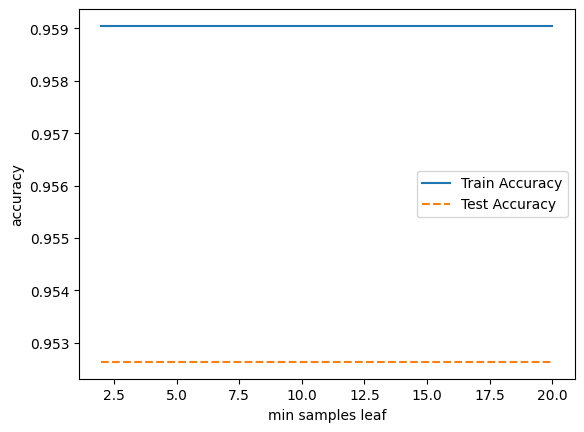

In [21]:
# 정확도를 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

In [22]:
# 최종 모델
gb_final = GradientBoostingClassifier(max_depth=6, n_estimators=20, learning_rate=0.02
                                      )
gb_final.fit(df_train_x_rd, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.960
Test Accuracy: 0.953

Test Confusion matrix: 
[[139   0]
 [  9  42]]
              precision    recall  f1-score   support

           0      0.939     1.000     0.969       139
           1      1.000     0.824     0.903        51

    accuracy                          0.953       190
   macro avg      0.970     0.912     0.936       190
weighted avg      0.956     0.953     0.951       190



In [24]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
10,rolling_temp,0.773
7,fur_soak_temp,0.189
1,pt_width,0.010
5,fur_heat_temp,0.008
9,fur_total_time,0.007
2,pt_length,0.005
16,spec_country_프랑스,0.004
13,spec_country_미국,0.002
18,purpose_OTHERS,0.001
3,fur_no,0.001


<ipython-input-25-062059cc6039>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance10 .sort_values("Importance", ascending=True, inplace = True)


Text(0, 0.5, '설명변수')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fun

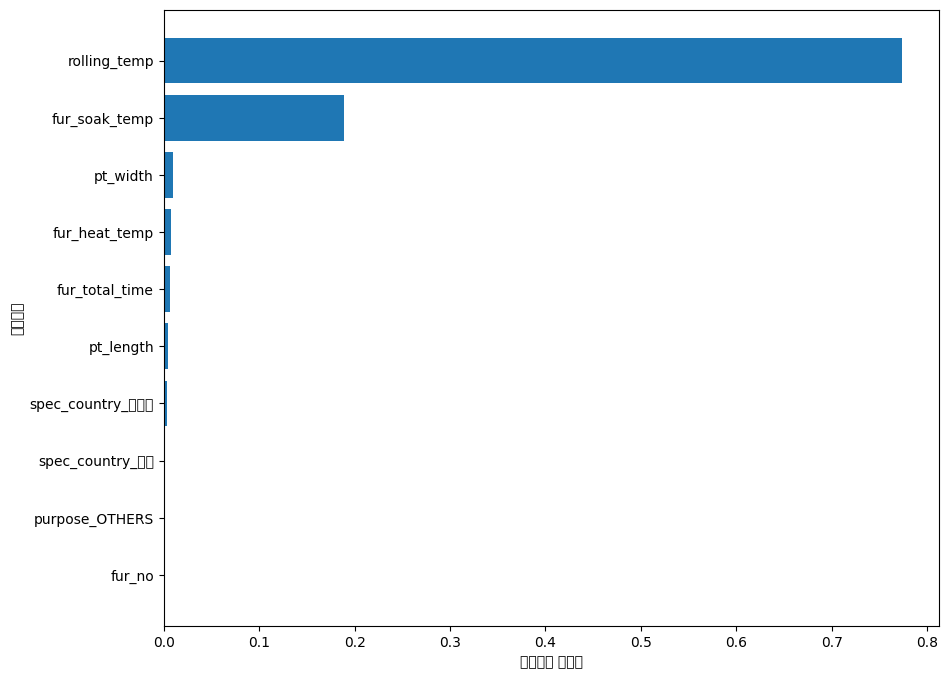

In [25]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위 10개 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance10 .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"])
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")